# Research Question

## How do different idicators of injury determine the severity of injury and how to interpret them?

Ans: Feature engineering provides insight for the interpretation of the factors for injury. Successful classification of injury followed by a sensitivity analysis helps identify the hierarchy of factors responsible for injury.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder as LE
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim import utils
import gensim.parsing.preprocessing as gsp
from gensim import models
import math
from scipy.spatial import distance
from scipy.stats import pearsonr

from random import sample
import sys

%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score


from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from collections import Counter
import xgboost as xgb
import time

#pathToBinVectors = 'GoogleNews-vectors-negative300.bin'
#model1 = models.KeyedVectors.load_word2vec_format(pathToBinVectors, binary=True)

In [2]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

class PhraseVector:
    def __init__(self, phrase):
        self.vector = self.PhraseToVec(phrase)
    # <summary> Calculates similarity between two sets of vectors based on the averages of the sets.</summary>
    # <param>name = "vectorSet" description = "An array of arrays that needs to be condensed into a single array (vector). In this class, used to convert word vecs to phrases."</param>
    # <param>name = "ignore" description = "The vectors within the set that need to be ignored. If this is an empty list, nothing is ignored. In this class, this would be stop words."</param>
    # <returns> The condensed single vector that has the same dimensionality as the other vectors within the vecotSet.</returns>
    def ConvertVectorSetToVecAverageBased(self, vectorSet, ignore = []):
        if len(ignore) == 0: 
            return np.mean(vectorSet, axis = 0)
        else: 
            return np.dot(np.transpose(vectorSet),ignore)/sum(ignore)

    def PhraseToVec(self, phrase):
        cachedStopWords = stopwords.words("english")
        phrase = phrase.lower()
        wordsInPhrase = [word for word in phrase.split() if word not in cachedStopWords]
        vectorSet = []
        for aWord in wordsInPhrase:
            try:
                wordVector=model1[aWord]
                vectorSet.append(wordVector)
            except:
                pass
        return self.ConvertVectorSetToVecAverageBased(vectorSet)

    # <summary> Calculates Cosine similarity between two phrase vectors.</summary>
    # <param> name = "otherPhraseVec" description = "The other vector relative to which similarity is to be calculated."</param>
    def CosineSimilarity(self, otherPhraseVec):
        cosine_similarity = np.dot(self.vector, otherPhraseVec) / (np.linalg.norm(self.vector) * np.linalg.norm(otherPhraseVec))
        try:
            if math.isnan(cosine_similarity):
                cosine_similarity=0
        except:
            cosine_similarity=0
        return cosine_similarity

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = scs.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def correlation_ratio(categories, measurements):
        fcat, _ = pd.factorize(categories)
        cat_num = np.max(fcat)+1
        y_avg_array = np.zeros(cat_num)
        n_array = np.zeros(cat_num)
        for i in range(0,cat_num):
            cat_measures = measurements[np.argwhere(fcat == i).flatten()]
            n_array[i] = len(cat_measures)
            y_avg_array[i] = np.average(cat_measures)
        y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
        numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
        denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
        if numerator == 0:
            eta = 0.0
        else:
            eta = numerator/denominator
        return eta

In [3]:
NONAVIATION_PATH = "nadb.xlsx"
AVIATION_PATH = "adb.xlsx"

nadf = pd.read_excel(NONAVIATION_PATH, sheet_name=1)
adf = pd.read_excel(AVIATION_PATH,sheet_name=1)

### preprocessing

#### Types of columns (features):

Datetime: 'FY', 'emonth', 'eweek', 'ehrmin'

Numerical: 'AGE', 'ehrmin', 'fd_words', 'ac_words', 'passage_words', 'hg_words',
       'ece_words', 'mech_words', 'cargo_words', 'gen_words'
            
Ordinal: 'PAYGRADE', 'PCN_C', 'SEX_C', 'FY', 'VESL_TYPE','emonth', 'eweek', 'actycommissioned', 'actydecommissioned','pcnfreq'

In [4]:
df1 = nadf.copy()

df1 = df1[~df1['BRIEF_NARR'].str.contains("civ", na=False,case=False)]
df1 = df1[(df1["AGE"] > 16) & (df1["AGE"] < 65)]

col = df1.columns.to_list()
#traint1 = np.array([datetime.strptime(d, '%m/%d/%y') for d in df1[col[17]]])
traint1 = np.array([datetime.strptime(str(d), "%Y-%m-%d %H:%M:%S" ) for d in df1[col[17]]])
traint2 = traint1 - max(traint1)
traint3 = -np.array([t.days for t in traint2])
df1[col[17]] = traint3.astype(float)
df1 = df1.assign(emonth = np.array([t.month for t in traint1]))
df1 = df1.assign(eweek = np.array([t.weekday() for t in traint1]))
df1 = df1.assign(ehrmin = np.array([t.hour*100 + t.minute for t in traint1]))
#df1 = df1.assign(emin = np.array([t.minute for t in traint1]))
col = df1.columns.to_list()

#select columns and drop missing data and duplicates
df1 = df1[[col[1]]+col[6:14] + col[17:20]+[col[21]] + col[23:]]
df1 = df1[df1['INJ_CLASSN_C'].notna()]
df1 = df1[df1['AREA_C'].notna()]
df1 = df1.drop_duplicates()

dfcopy = df1.copy()

dfor_sex = dfcopy['SEX_C']
dfor_age = dfcopy['AGE']
dfor_pg = dfcopy['PAYGRADE']


#df1['AGE'].fillna(22, inplace=True) #replace missing age with median age
#df1['AGE'] = df1['AGE'].replace(99,22)
#df1['AGE'] = df1['AGE'].replace(0,22)
#df1['PAYGRADE'].fillna(4, inplace = True) #replace missing paygrade with highest value

In [8]:
nadf['AGE'].isna().sum()/ (len(nadf['AGE']) - nadf['AGE'].isna().sum())

0.05730369515011547

In [6]:
cats = ['A', 'B', 'C', 'D','E','F','G','H']
for i in range(len(cats)):
    df1[col[8]] = df1[col[8]].replace(cats[i], i)
    
cats = ['A', 'B', 'C', 'D','E','F','G','H']
for i in range(len(cats)):
    df1[col[21]] = df1[col[21]].replace(cats[i], i)
    
    
#paygrade    
cats = ["UNK","MIDN","E01","E02","E03","E04","E05","E06","E07","E08","E09","O01","O02","W02","O03","W04","O04","W05","O05","O06","GS12"]
for i in range(len(cats)):
    df1[col[1]] = df1[col[1]].replace(cats[i], i)
    
cats = ['M','F']
for i in range(len(cats)):
    df1['SEX_C'] = df1['SEX_C'].replace(cats[i], i)
    
cats = ['CV','CVN']
for i in range(len(cats)):
    df1['VESL_TYPE'] = df1['VESL_TYPE'].replace(cats[i], i)
    
#compressing into 3 classes
#a = np.array(df1["INJ_CLASSN_C"].values.tolist())
a = np.array(df1["INJ_CLASSN_C"].values.tolist())
a = np.where(a < 3, 0, a)
a = np.where((a>=3) & (a < 4), 1, a)
a = np.where(a == 4, 2, a)
a = np.where(a > 4, 3, a)
df1["INJ_CLASSN_C"] = a.tolist()


    
df1["PCN_C"][df1["PCN_C"].isna()] = 'MS-05-00' #most common occuring 
df1["PCN_C"]=df1["PCN_C"].str[:2]#.split('-')

#carrier name cleanup and replacing them with dates
cleanup_nums = {"ACTY_NAME_LONG": {
                                     "USS HARRY S TRUMAN (CVN -75)" : "TRUMAN",
"USS RONALD REAGAN  (CVN-76)"  : "REAGAN",
"USS JOHN C STENNIS (CVN-74)"  : "STENNIS",
"USS DWIGHT D EISENHOWER (CVN-69)" : "EISENHOWER",
"USS NIMITZ  (CVN 68)" : "NIMITZ",
"USS GEORGE H W BUSH (CVN-77)" : "BUSH",
"USS ENTERPRISE"  : "ENTERPRISE",
"USS GEORGE WASHINGTON (CVN-73)" : "WASHINGTON",
"USS THEODORE ROOSEVELT" : "ROOSEVELT",
"USS ABRAHAM LINCOLN"  : "LINCOLN",
"GEORGE WASHINGTON"  : "WASHINGTON",
"USS THEODORE ROOSEVELT  (CVN-71)" : "ROOSEVELT",
"USS CARL VINSON  (CVN-70)" : "VINSON",
"USS ABRAHAM LINCOLN (CVN-72)" : "LINCOLN",
"USS JOHN F KENNEDY" : "KENNEDY",
"NIMITZ"  : "NIMITZ",
"RONALD REAGAN"   : "REAGAN",
"ABRAHAM LINCOLN" : "LINCOLN",
"JOHN C STENNIS"  : "STENNIS",
"USS GERALD R FORD (CVN 78)" : "FORD",
"CARL VINSON" : "VINSON",
"CVN 78 GERALD R FORD PCU" : "FORD",
"KITTY HAWK" : "HAWK",
"ENTERPRISE" : "ENTERPRISE",
"USS ENTERPRISE (CVN 65)" : "ENTERPRISE"},
               
               "PCN_C": {"DV" : "MS",
"RE"  : "TR",
"TL"  : "PR"}
               }
df1.replace(cleanup_nums, inplace=True)

df1['actycommissioned'] = df1['ACTY_NAME_LONG']
df1['actydecommissioned'] = df1['ACTY_NAME_LONG']

netcat = { "actycommissioned" : {'TRUMAN'  :1998,
'REAGAN'  :2003,
'STENNIS' :1995,
'NIMITZ'     : 1975,
'EISENHOWER' : 1977,
'WASHINGTON' : 1992,
'ROOSEVELT'   : 1986,
'BUSH'     :2009,
'LINCOLN'  : 1989,
'ENTERPRISE'  : 1961,
'VINSON'   :1982,
'KENNEDY'   :1968,
'FORD'  : 2017,
'HAWK'     : 1961}, 
          "actydecommissioned" : {'TRUMAN'  :2020,
'REAGAN'  :2020,
'STENNIS' :2020,
'NIMITZ'     : 2020,
'EISENHOWER' : 2020,
'WASHINGTON' : 2020,
'ROOSEVELT'   : 2020,
'BUSH'     :2020,
'LINCOLN'  : 2020,
'ENTERPRISE'  : 2017,
'VINSON'   :2020,
'KENNEDY'   :2007,
'FORD'  : 2020,
'HAWK'     : 2009}
         }

df1['actyrank'] = df1['ACTY_NAME_LONG']

netcat1 = { "actyrank" : {'TRUMAN'  :10,
'REAGAN'  :11,
'STENNIS' :9,
'NIMITZ'     : 3,
'EISENHOWER' : 4,
'WASHINGTON' : 8,
'ROOSEVELT'   : 6,
'BUSH'     :12,
'LINCOLN'  : 7,
'ENTERPRISE'  : 1,
'VINSON'   :5,
'KENNEDY'   :2,
'FORD'  : 13,
'HAWK'     : 0}
         }
df1.replace(netcat, inplace=True)
df1.replace(netcat1, inplace=True)


C:\Users\sayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
df1['INJ_CLASSN_C'].value_counts()

2    3927
3    1814
1    1093
0      27
Name: INJ_CLASSN_C, dtype: int64

In [8]:
nadf['PCN_C'].value_counts()

MS-05-00    1065
MS-05-03     464
MS-05-04     427
ZZ-99-00     242
ID-99-00     230
            ... 
MS-08-08       1
ID-14-01       1
WN-02-03       1
ID-03-03       1
RE-15-01       1
Name: PCN_C, Length: 292, dtype: int64

In [9]:
'''
AV - Aviation-related Activities, Maintenance, Aircraft Maintenance, Handling, Moving, etc. Aboard CV
ID - Mechanical Assembly/Repair, Multiple Operations, Electrical, Brush/Rolle
SR - Multiple Operations, Handling , Cutting/Slicing, Trash/Garbage - Disposal
MS = DV - walking, running
CE - Handling Supplies, Multiple Operations, Handling Equipment
CN - Preventive (PMS), Corrective, Other, Multiple Operations
WN - Handling, Maintenance, Transporting, On/Off loading
CL - Housekeeping/Cleaning, Washing dishes, Cleaning garage/storage 
MD - Multiple Operations, Sterilization, Anesthesia Administration 
ZZ - Threshold shift (auditory fatigue)
PR = TL =  - Supervision
TR = RE - Weight Lifting, Jogging/Running, Unit Training 
SP - Basketball, Football,Boating
'''
df1['pcnfreq'] = df1['PCN_C']
df1.pcnfreq = df1.pcnfreq.map(df1.pcnfreq.value_counts())
#pcn_c wrt lvl of importance
cats = ["AV","ID","SR","MS","CE","CN","WN","CL","MD","ZZ","PR","TR","SP"]
for i in range(len(cats)):
    df1['PCN_C'] = df1['PCN_C'].replace(cats[i], i)
    
#clean text
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           #gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

df1['AREA'] = df1.apply(lambda row: clean_text(row['AREA']), axis=1)

In [10]:
target_for_values = {
    'pw': ['ladder', 'passageway', 'escape trunk','bridge operational areas ship control','bridge','signal bridge','bridge wing','pathway sidewalk','pedestrian crossing'], 
    'fd': ['flight deck', 'deck', 'main deck','fueling space shop','jet shop space shop','jet engine space shop',
          'aircraft fueling space shop','fuels repair space shop','fuel oil space shop','fuel test space shop','launcher space shop',
          'fueling space','flight deck triage','upper deck','refueling pits','landing zone','personnel landing'],
    'aa': ['hangar bay','wpns ord department space','catapult space shop','aviation air aimd space shop',
          'avionics space shop','arresting gear machinery space shop','unrep ras space shop','ordnance space shop',
          'elevator','airframes space shop','maint support tool space shop','aircraft elevator space shop','waist catapult space shop',
          'ordnance gun space shop','elevator space shop','crash salvage aviation fuel repair space shop','launch access space shop',
          'weapons dept office space','elevator space','ciws aviation space','shop ordnance','hangar deck','elevated area','maintenance area','weapons ordnance','hangar','paraloft'],
    'ma': ['main machinery room mmr','reactor room','shaft alley','machinery space shop','pump room','engine room',
          'machinery room mer','auxiliary machinery room amr aux','machine space shop','metalsmith machine space shop',
          'aircraft elevator machinery space shop','machine weld space shop','elevator machinery space shop','refrigeration machinery room',
          'elevator machinery space','capstan machinery space shop','rast machinery room','refrigeration machinery space shop',
          'boiler space shop','diesel generator space shop','hydraulics space shop','engine test space shop','emergency generator space shop','gear space shop','valve space shop','oxidizer space shop','cylinder space shop','obogs space shop','cht boiler space shop','compressor space shop',
          'pump space','cht pump room space','generator space','auxiliary boiler space','oil pump space','mechanical calibration facility','engine areas','incinerator room','pulper shredder room','steering gear room','motor generator room',
        'plastic waste processor room','weapons forklift','ciws','conveyor','vertical package conveyor','fan'],
    'ca':['magazine','supply stores cargo','equipment space shop','armory space shop','gun space shop','diesel space shop','gun support space shop','emergency diesel space shop','storage battery space shop',
         'equipment space','supply dept office space','master arms space','equipment space storeroom','chem cbr warfare defense space',
         'ships service storeroom', 'ships store mini mart','general storeroom','equipment storeroom','utility storeroom','cylinder storeroom','paint storeroom','main storeroom',
      'cargo hold','flammable cargo','holds supply areas','handling area','armory'],
    'ea': ['engineering aux repair','ground support equipment gse space shop','electrical space shop','battery space shop','electronic repair space shop',
      'socket pouring space shop','electrical service space shop','gyro space shop','electrical rewind space shop','ndi space shop','nucleonics space shop','electrical damage control space shop',
      'acid battery space shop','electrical tool space shop','lighting space shop','helo repair space shop','nixie equipment space shop',
          'communications space','switchboard space','radar room','switchboard room','ops comms ship control','radio','audio booth'],
    'ga': ['repair space office shop','department space shop','air department space','division space office shop',
           'general space shop','administrative dept space','boat space shop','calibration space shop','space shop','division office space shop','pipe space shop','boatswains space shop',
      'carpenter space shop','area functional physical space shops','tool issue space shop','handling space shop','repair space shop','metal pipe space shop','ras winch space shop','metalsmith space shop',
      'cleaning gear space shop','hull repair space shop','lieutenants space shop','utility space shop','central admin space shop','survival equipment space shop','forklift space shop',
      'composite space shop','corrosion control space shop','display repair space shop','filter space shop',
      'ciws aviation space shop','filter cleaning space shop','tire wheel space shop','hose tube space shop','ejection seat space shop','towed array space shop',
          'department space office','control space','general workshop space','department office space','division space office',
      'food service office space','division space','garbage disposal space','division office space','general medical space area',
      'space office shop','general operations space','ops space office','public affairs space','safety officers space',
      'utility space','cleaning gear space','disbursing space','executive officers space','filter space','forklift space',
      'vehicle space','director space','classified document destruction space','general workshop','rewind shop','portable tool shop area','department office','office building','medical department office admin',
          'engineering log room','trash room','trash pulper room','utility room','issue room','log room','motor pool garage','garage',
          'administrative areas','administrative','combat information center cic','void','test lab','support facility',
      'central admin','steering','battle dressing station','hazmincen','sses','photo lab','air government','hazmat reuse','industrial facilities',
      'incinerator','paint mixing issue','open ocean','navigation','trash disposal operation','oil analysis lab','transports'],
    'cr':['galley','crew mess','crew berthing','head','mess deck','crew space','physical fitness room','crew scullery',
         'scullery','wardroom galley','gym','crew space shop','recreation area space','general habitability space','chaplain space','training space',
         'flag officer galley','crew laundry','crew shelter', 'crew barber', 'medical crew mess room','chiefs cpo mess','chiefs mess','wardroom mess','class mess',
      'quarterdeck','medical treatment room','main medical area','medical dental','medical records room','recreational area',
      'cpo nco galley','wardroom','stateroom','washroom','bread room','exam room','veg prep room','wardroom scullery','minor operating room',
       'ready room','wardroom pantry','sterilizing room','conference room','home residence area','inpatient area','obstacle course','laundry','laundry press','laundry issue','habitability',
      'bakery','lounge', 'vestibule','library','basketball court','chiefs cpo berthing','house','cvic','athletic field',
       'shower','cpo nco scullery','cleaning gear issue locker','gear locker','football field','dental stowage','troop berthing','dental ray','water closet',
      'ward','learning resource center','hiking jogging path','chain locker','preventive dentistry','tennis court','blood bank','commercial building',
       'club','facility school','cabin','shower water closet','barracks','enlisted quarters'],
    'sp':['fantail','brow','berthing area','forecastle','topside','pier','hoist space shop','structures space shop','ram space shop','canvas space shop','crane space shop','canvas bunting space shop',
         'anchor windlass space','decon space station','winch crane space','fan room','amidships','non govt ship unknown','non govt ship','concrete asphalt plant','operational industrial building plant',
      'barge','bilge','port bow','boom','mast','platform','hull underwater tanks voids','antenna','stern','mount','ram',
      'hold','brig','tank','pool','kingpost','small boat','sail loft','yard']
}

In [11]:
for k, v in target_for_values.items():
    df1['AREA']=df1['AREA'].replace(dict.fromkeys(v,k))

In [12]:
cats = ["fd","pw","aa","ma","ea","ca","ga","sp","cr"]
for i in range(len(cats)):
    df1['AREA'] = df1['AREA'].replace(cats[i], i)

In [13]:
df1 = df1.dropna()

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4610 entries, 0 to 7323
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PAYGRADE            4610 non-null   float64
 1   PCN_C               4610 non-null   int64  
 2   AREA_C              4610 non-null   object 
 3   INJ_CLASSN_C        4610 non-null   int64  
 4   AGE                 4610 non-null   float64
 5   SEX_C               4610 non-null   int64  
 6   AREA                4610 non-null   int64  
 7   PCN_NAME            4610 non-null   object 
 8   INJ_CLASSN          4610 non-null   object 
 9   EVENT_DATE_TIME     4610 non-null   float64
 10  FY                  4610 non-null   int64  
 11  BRIEF_NARR          4610 non-null   object 
 12  EVENT_SEVTY_C       4610 non-null   int64  
 13  ACTY_NAME_LONG      4610 non-null   object 
 14  VESL_TYPE           4610 non-null   int64  
 15  emonth              4610 non-null   int32  
 16  eweek 

In [15]:
# 'EVENT_DATE_TIME'??
# remove
df1.drop(['AREA_C','EVENT_DATE_TIME','pcnfreq','PCN_NAME','EVENT_SEVTY_C','INJ_CLASSN', 'BRIEF_NARR','ACTY_NAME_LONG','actycommissioned','actydecommissioned',
         'eweek'],axis=1,inplace= True)

In [16]:
df1.columns

Index(['PAYGRADE', 'PCN_C', 'INJ_CLASSN_C', 'AGE', 'SEX_C', 'AREA', 'FY',
       'VESL_TYPE', 'emonth', 'ehrmin', 'actyrank'],
      dtype='object')

In [17]:
df1.T

,0,1,2,3,4,7,14,16,17,19,...,7311,7312,7314,7315,7316,7318,7320,7321,7322,7323
PAYGRADE,4.0,5.0,6.0,5.0,4.0,4.0,3.0,4.0,4.0,5.0,...,4.0,4.0,6.0,6.0,4.0,3.0,5.0,6.0,5.0,4.0
PCN_C,3.0,3.0,1.0,3.0,3.0,3.0,1.0,2.0,5.0,6.0,...,3.0,3.0,2.0,6.0,12.0,2.0,0.0,3.0,4.0,3.0
INJ_CLASSN_C,2.0,2.0,2.0,1.0,3.0,3.0,2.0,2.0,3.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
AGE,21.0,26.0,42.0,24.0,25.0,19.0,20.0,19.0,20.0,24.0,...,33.0,24.0,29.0,19.0,21.0,22.0,28.0,31.0,22.0,23.0
SEX_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AREA,1.0,1.0,1.0,3.0,6.0,6.0,2.0,6.0,2.0,3.0,...,5.0,0.0,4.0,2.0,8.0,8.0,6.0,2.0,8.0,7.0
FY,2006.0,2006.0,2006.0,2006.0,2006.0,2006.0,2006.0,2006.0,2004.0,2004.0,...,2019.0,2019.0,2019.0,2019.0,2019.0,2019.0,2019.0,2019.0,2019.0,2019.0
VESL_TYPE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
emonth,4.0,4.0,9.0,12.0,12.0,11.0,2.0,10.0,7.0,8.0,...,4.0,7.0,3.0,6.0,4.0,4.0,4.0,7.0,7.0,3.0
ehrmin,230.0,2200.0,1020.0,1230.0,1930.0,1700.0,1300.0,1030.0,930.0,800.0,...,15.0,1200.0,1230.0,1900.0,2000.0,1030.0,2000.0,1445.0,1400.0,1430.0


### tests

In [18]:
import pandas as pd
import scipy.stats as scs


def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    #df_col1, df_col2 = df[col1], df[col2]
    return scs.chi2_contingency(pd.crosstab(df[col1], df[col2]))

def calculate_chipvals(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            #print(r,c)
            pvalues[r][c] = round(chi_square_of_df_cols(df, r, c)[1], 4)
    return pvalues

def calculate_chivals(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            #print(r,c)
            pvalues[r][c] = round(chi_square_of_df_cols(df, r, c)[0], 4)
    return pvalues

In [19]:
#konglomorov smirnov test for imputed values
from scipy.stats import ks_2samp

x = dfor_age
x = x.dropna()
y = df1['AGE']

print(ks_2samp(x, y))

Ks_2sampResult(statistic=0.008577830429530172, pvalue=1.0)


In [20]:
x = dfor_pg
x = x.dropna()

cats = ["UNK","MIDN","E01","E02","E03","E04","E05","E06","E07","E08","E09","O01","O02","W02","O03","W04","O04","W05","O05","O06","GS12"]
for i in range(len(cats)):
    x = x.replace(cats[i], i)

y = df1['PAYGRADE']

x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

print(ks_2samp(x, y))

obs = pd.concat([x, y[:len(x.to_numpy())]], axis=1, ignore_index=True)
calculate_chivals(obs)

Ks_2sampResult(statistic=0.00817629164755098, pvalue=1.0)


,0,1
0,87590,349.797
1,349.797,87590


In [21]:
calculate_chipvals(obs)

,0,1
0,0,0.6541
1,0.6541,0


In [22]:
x = dfor_sex
x = x.dropna()

cats = ['M','F']
for i in range(len(cats)):
    x = x.replace(cats[i], i)

y = nadf['SEX_C']

cats = ['M','F']
for i in range(len(cats)):
    y = y.replace(cats[i], i)

x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

print(ks_2samp(x, y))

obs = pd.concat([x, y[:len(x.to_numpy())]], axis=1, ignore_index=True)
calculate_chivals(obs)

Ks_2sampResult(statistic=0.04641638225255973, pvalue=1.0)


,0,1
0,6537.48,2.9089
1,2.9089,6537.41


In [23]:
calculate_chipvals(obs)

,0,1
0,0,0.0881
1,0.0881,0


In [24]:
## pearsons correlation
df1[['AGE','FY','ehrmin']].corr()

,AGE,FY,ehrmin
AGE,1.000000,0.002175,-0.034753
FY,0.002175,1.000000,0.017773
ehrmin,-0.034753,0.017773,1.000000


In [25]:
calculate_pvalues(df1[['AGE','FY','ehrmin']])

,AGE,FY,ehrmin
AGE,0,0.8826,0.0183
FY,0.8826,0,0.2276
ehrmin,0.0183,0.2276,0


### chi squared contingency test

### Nominal

In [26]:
df1[['PAYGRADE', 'PCN_C', 'SEX_C', 'AREA','VESL_TYPE', 'emonth', 'actyrank']]

,PAYGRADE,PCN_C,SEX_C,AREA,VESL_TYPE,emonth,actyrank
0,4.0,3,0,1,1,4,8
1,5.0,3,0,1,1,4,8
2,6.0,1,0,1,1,9,4
3,5.0,3,0,3,1,12,11
4,4.0,3,0,6,1,12,6
...,...,...,...,...,...,...,...
7318,3.0,2,0,8,1,4,10
7320,5.0,0,0,6,1,4,7
7321,6.0,3,0,2,1,7,7
7322,5.0,4,0,8,1,7,7


In [27]:
#print(round(chi_square_of_df_cols(df1, 'PAYGRADE', 'FY')[1],4))
calculate_chipvals(df1[['PAYGRADE', 'PCN_C', 'SEX_C', 'AREA','VESL_TYPE', 'emonth', 'actyrank']])

,PAYGRADE,PCN_C,SEX_C,AREA,VESL_TYPE,emonth,actyrank
PAYGRADE,0,0,0.0033,0,0.9848,0.2381,0.1366
PCN_C,0,0,0,0,0.0083,0.0315,0
SEX_C,0.0033,0,0,0,0.0075,0.9124,0
AREA,0,0,0,0,0.0472,0.0138,0
VESL_TYPE,0.9848,0.0083,0.0075,0.0472,0,0.237,0
emonth,0.2381,0.0315,0.9124,0.0138,0.237,0,0
actyrank,0.1366,0,0,0,0,0,0


#### cramers v

In [28]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = scs.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def calculate_cramers(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            #print(r,c)
            pvalues[r][c] = round(cramers_v(df1[r], df1[c]), 4)
    return pvalues

In [29]:
calculate_cramers(df1[['PAYGRADE', 'PCN_C', 'SEX_C', 'AREA','VESL_TYPE', 'emonth', 'actyrank']])

,PAYGRADE,PCN_C,SEX_C,AREA,VESL_TYPE,emonth,actyrank
PAYGRADE,1,0.0442,0,0.0154,0.0382,0.0204,0.1085
PCN_C,0.0442,1,0.1079,0.2891,0.0556,0.0246,0.064
SEX_C,0,0.1079,0.9994,0.0929,0.0365,0,0.0833
AREA,0.0154,0.2891,0.0929,1,0.0408,0.0294,0.0614
VESL_TYPE,0.0382,0.0556,0.0365,0.0408,0.9905,0.0252,0.9624
emonth,0.0204,0.0246,0,0.0294,0.0252,1,0.0753
actyrank,0.1085,0.064,0.0833,0.0614,0.9624,0.0753,1


In [30]:
#normality tests
from scipy import stats

In [31]:
print(stats.kstest(df1['AGE'], 'norm'))
print(stats.kstest(df1['PAYGRADE'], 'norm'))

KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=0.9763821890930355, pvalue=0.0)


In [32]:
stats.spearmanr(df1[['PAYGRADE','AGE']])

SpearmanrResult(correlation=0.6264270117225146, pvalue=0.0)

In [33]:
stats.mannwhitneyu(df1['PAYGRADE'],df1['AGE'])

MannwhitneyuResult(statistic=1361.0, pvalue=0.0)

### Ordinal data

In [34]:
from scipy import stats

def calculate_kendaltau(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            #print(r,c)
            pvalues[r][c] = round(stats.kendalltau(df[r], df[c]).pvalue, 4)
    return pvalues

def calculatespearr(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            #print(r,c)
            pvalues[r][c] = round(stats.spearmanr(df[[r,c]])[0], 4)
    return pvalues

def calculatespearp(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            #print(r,c)
            pvalues[r][c] = round(stats.spearmanr(df[[r,c]])[1], 4)
    return pvalues


calculate_kendaltau(df1[['PAYGRADE', 'emonth','actyrank']])

,PAYGRADE,emonth,actyrank
PAYGRADE,0,0.3378,0.4075
emonth,0.3378,0,0.0613
actyrank,0.4075,0.0613,0


In [35]:
calculatespearp(df1)

,PAYGRADE,PCN_C,INJ_CLASSN_C,AGE,SEX_C,AREA,FY,VESL_TYPE,emonth,ehrmin,actyrank
PAYGRADE,0,0.0182,0,0,0,0.5056,0.3476,0.1631,0.3378,0.2553,0.4035
PCN_C,0.0182,0,0,0.0002,0.0671,0,0.0004,0.7543,0.8934,0.089,0.7708
INJ_CLASSN_C,0,0,0,0.0013,0,0,0,0.0348,0.0885,0.2363,0.1284
AGE,0,0.0002,0.0013,0,0,0.0167,0.2711,0.3061,0.9725,0.0527,0.5443
SEX_C,0,0.0671,0,0,0,0.0449,0,0.0046,0.4777,0.4366,0.0001
AREA,0.5056,0,0,0.0167,0.0449,0,0.5769,0.5784,0.6717,0.183,0.7382
FY,0.3476,0.0004,0,0.2711,0,0.5769,0,0,0.428,0.3664,0
VESL_TYPE,0.1631,0.7543,0.0348,0.3061,0.0046,0.5784,0,0,0.2069,0.9118,0
emonth,0.3378,0.8934,0.0885,0.9725,0.4777,0.6717,0.428,0.2069,0,0.4743,0.0505
ehrmin,0.2553,0.089,0.2363,0.0527,0.4366,0.183,0.3664,0.9118,0.4743,0,0.093


In [36]:
calculatespearr(df1)

,PAYGRADE,PCN_C,INJ_CLASSN_C,AGE,SEX_C,AREA,FY,VESL_TYPE,emonth,ehrmin,actyrank
PAYGRADE,1,0.0348,0.0788,0.6264,-0.0768,-0.0098,-0.0138,-0.0205,-0.0141,-0.0168,0.0123
PCN_C,0.0348,1,-0.0865,0.0546,0.027,0.096,0.0522,0.0046,-0.002,0.0251,-0.0043
INJ_CLASSN_C,0.0788,-0.0865,1,0.0473,-0.0974,0.087,-0.0618,0.0311,0.0251,-0.0174,0.0224
AGE,0.6264,0.0546,0.0473,1,-0.0906,-0.0352,0.0162,-0.0151,0.0005,-0.0285,0.0089
SEX_C,-0.0768,0.027,-0.0974,-0.0906,1,-0.0295,0.0937,0.0417,-0.0105,-0.0115,0.0589
AREA,-0.0098,0.096,0.087,-0.0352,-0.0295,1,-0.0082,-0.0082,-0.0062,-0.0196,-0.0049
FY,-0.0138,0.0522,-0.0618,0.0162,0.0937,-0.0082,1,0.1432,0.0117,0.0133,0.189
VESL_TYPE,-0.0205,0.0046,0.0311,-0.0151,0.0417,-0.0082,0.1432,1,-0.0186,0.0016,0.1218
emonth,-0.0141,-0.002,0.0251,0.0005,-0.0105,-0.0062,0.0117,-0.0186,1,-0.0105,-0.0288
ehrmin,-0.0168,0.0251,-0.0174,-0.0285,-0.0115,-0.0196,0.0133,0.0016,-0.0105,1,0.0247


#### Nominal vs ordinal

In [37]:
df1f = df1.reindex(columns=df1.columns)

In [38]:
print("NOM vs ORDINAL")
print('PAYGRADE: ',correlation_ratio(df1['PCN_C'], df1['PAYGRADE']))
print('SEX: ',correlation_ratio(df1['SEX_C'], df1['PAYGRADE']))
print('TYPE: ',correlation_ratio(df1['VESL_TYPE'], df1['PAYGRADE']))

NOM vs ORDINAL
PAYGRADE:  0.07310008223857263
SEX:  0.005699956452503543
TYPE:  6.265991427236985e-05


In [39]:
df1 = df1.drop(['VESL_TYPE'], axis=1)

In [40]:

calculate_kendaltau(df1[['PAYGRADE','AGE']])

,PAYGRADE,AGE
PAYGRADE,0,0
AGE,0,0


In [41]:
df1.columns

Index(['PAYGRADE', 'PCN_C', 'INJ_CLASSN_C', 'AGE', 'SEX_C', 'AREA', 'FY',
       'emonth', 'ehrmin', 'actyrank'],
      dtype='object')

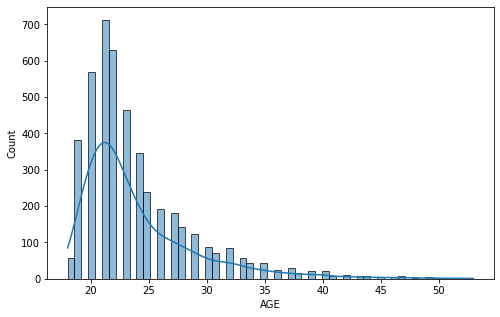

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.histplot(data=df1, x="AGE", kde=True, ax=ax)
plt.show()

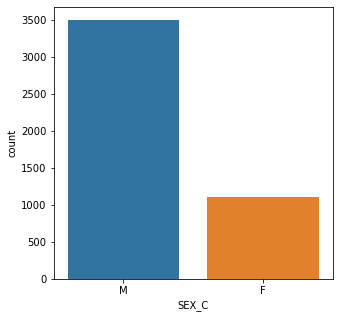

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
sns.countplot(data=df1, x="SEX_C", ax = ax)
plt.xticks(range(2),['M','F'])
plt.show()

ValueError: Could not interpret input 'VESL_TYPE'

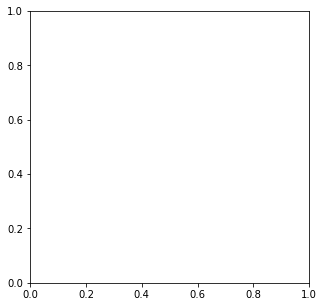

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
sns.countplot(data=df1, x="VESL_TYPE", ax = ax)
plt.xticks(range(2),['CV','CVN'])
plt.show()

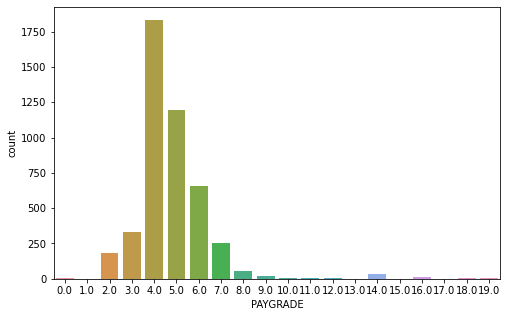

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.countplot(data=df1, x="PAYGRADE", ax=ax)
#plt.xticks(range(2),['M','F'])
plt.show()

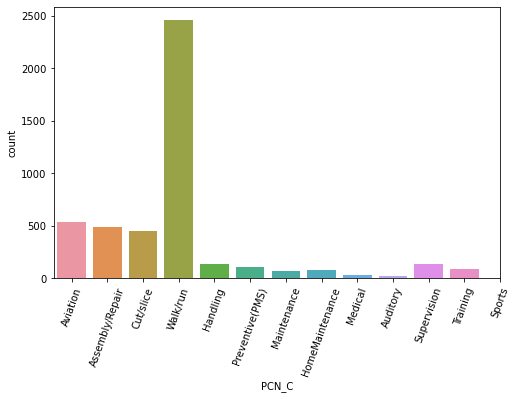

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
labels = ["Aviation","Assembly/Repair","Cut/slice","Walk/run","Handling","Preventive(PMS)","Maintenance","HomeMaintenance","Medical","Auditory","Supervision","Training","Sports"]
sns.countplot(data=df1, x="PCN_C", ax = ax)
plt.xticks(range(len(labels)),labels, rotation=70)
plt.show()

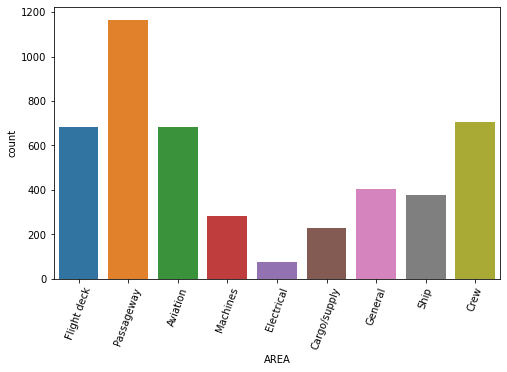

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
labels = ["Flight deck","Passageway","Aviation","Machines","Electrical","Cargo/supply","General","Ship","Crew"]
sns.countplot(data=df1, x="AREA", ax = ax)
plt.xticks(range(len(labels)),labels, rotation=70)
plt.show()

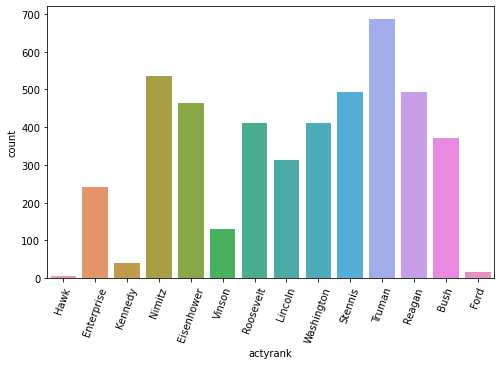

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
labels = ["Hawk","Enterprise","Kennedy","Nimitz","Eisenhower","Vinson","Roosevelt","Lincoln","Washington","Stennis","Truman",
         "Reagan","Bush","Ford"]
sns.countplot(data=df1, x="actyrank",ax = ax)
plt.xticks(range(len(labels)),labels, rotation=70)
plt.show()

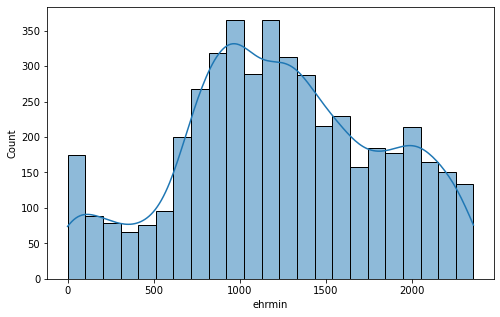

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.histplot(data=df1, x="ehrmin",kde=True,ax = ax)
plt.show()

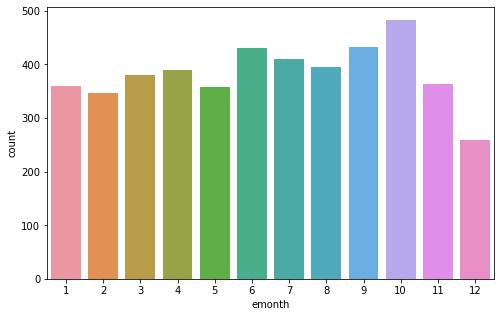

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.countplot(data=df1, x="emonth", ax = ax)
plt.show()

In [51]:
df1.columns

Index(['PAYGRADE', 'PCN_C', 'INJ_CLASSN_C', 'AGE', 'SEX_C', 'AREA', 'FY',
       'emonth', 'ehrmin', 'actyrank'],
      dtype='object')

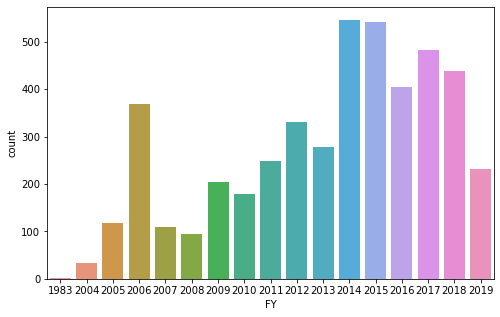

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.countplot(data=df1, x="FY",ax = ax)
plt.show()

In [53]:
df1 = df1.drop(['PAYGRADE'], axis=1)

### Sampling

In [89]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score


from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from collections import Counter
import xgboost as xgb
import time

Counter({1: 2837, 2: 995, 0: 835})
Counter({0: 835, 1: 835, 2: 835})
Class=0, n=835 (33.333%)
Class=1, n=835 (33.333%)
Class=2, n=835 (33.333%)


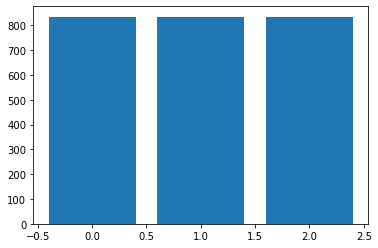

In [48]:
#undersampling
from imblearn.under_sampling import NearMiss
# define dataset
df2 = df1.copy()
df2.drop(['INJ_CLASSN_C'],axis=1,inplace= True)
X, y = df2, df1['INJ_CLASSN_C']
# summarize class distribution
counter = Counter(y)
print(counter)
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Counter({2: 2837, 3: 994, 1: 818, 0: 17})
Class=2, n=2837 (60.802%)
Class=1, n=818 (17.531%)
Class=3, n=994 (21.303%)
Class=0, n=17 (0.364%)


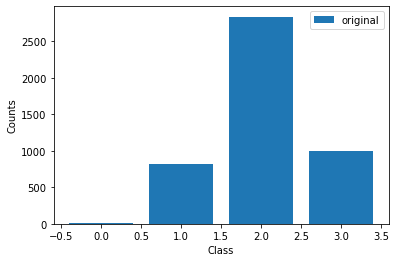

In [90]:
counter1 = Counter(df1['INJ_CLASSN_C'])
print(counter1)
for k,v in counter1.items():
	per = v / len(df1['INJ_CLASSN_C']) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# define the undersampling method

# plot the distribution
plt.bar(counter1.keys(), counter1.values(), label='original')
#plt.bar(counter.keys(), counter.values(), label = 'sampled')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [88]:
dx = pd.concat([X, y], ignore_index=True, axis = 1)
X.columns = ['PAYGRADE', 'PCN_C', 'AGE', 'FY',
       'emonth', 'eweek', 'ehrmin', 'actycommissioned', 'fd_words', 'ac_words', 'passage_words',
       'ece_words']
dx.columns = ['PAYGRADE', 'PCN_C', 'AGE', 'FY',
       'emonth', 'eweek', 'ehrmin', 'actycommissioned', 'fd_words', 'ac_words', 'passage_words',
       'ece_words','INJ_CLASSN_C']

In [89]:
X = pd.get_dummies(X, 
               prefix = ['PCN_C','AREA'], 
               columns = ['PCN_C','AREA'], 
               drop_first=True, dtype = int) 

## EDA

### Continuous data

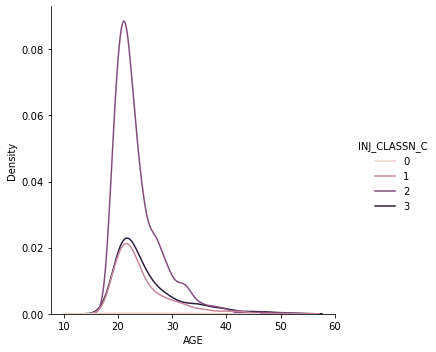

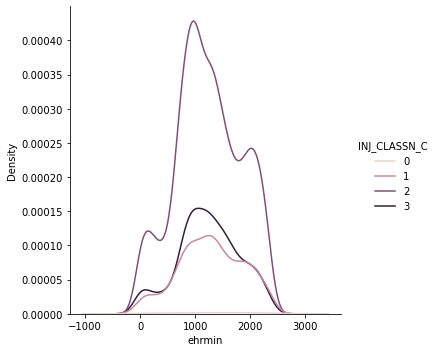

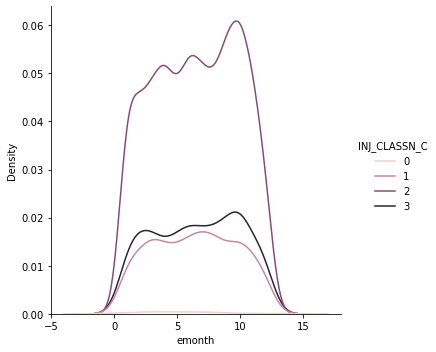

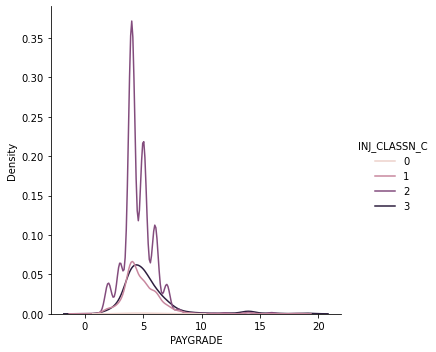

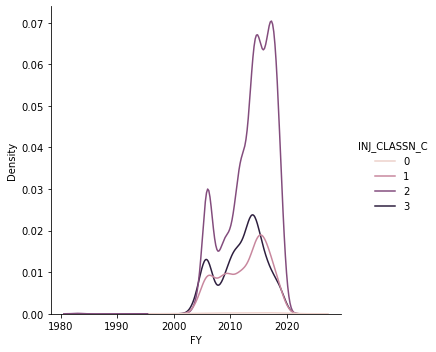

In [144]:
['PAYGRADE', 'PCN_C', 'INJ_CLASSN_C', 'AGE', 'SEX_C', 'FY', 'VESL_TYPE',
       'emonth', 'eweek', 'ehrmin', 'actycommissioned', 'actydecommissioned',
       'pcnfreq', 'fd_words', 'ac_words', 'passage_words', 'hg_words',
       'ece_words', 'mech_words', 'cargo_words', 'gen_words']
dx=df1

sns.displot(dx, x="AGE", hue="INJ_CLASSN_C", kind = 'kde')
plt.show()

sns.displot(dx, x="ehrmin", hue="INJ_CLASSN_C", kind = 'kde')
plt.show()

sns.displot(dx, x="emonth", hue="INJ_CLASSN_C", kind = 'kde')
plt.show()

sns.displot(dx, x="PAYGRADE", hue="INJ_CLASSN_C", kind = 'kde')
plt.show()

sns.displot(dx, x="FY", hue="INJ_CLASSN_C", kind = 'kde')
plt.show()

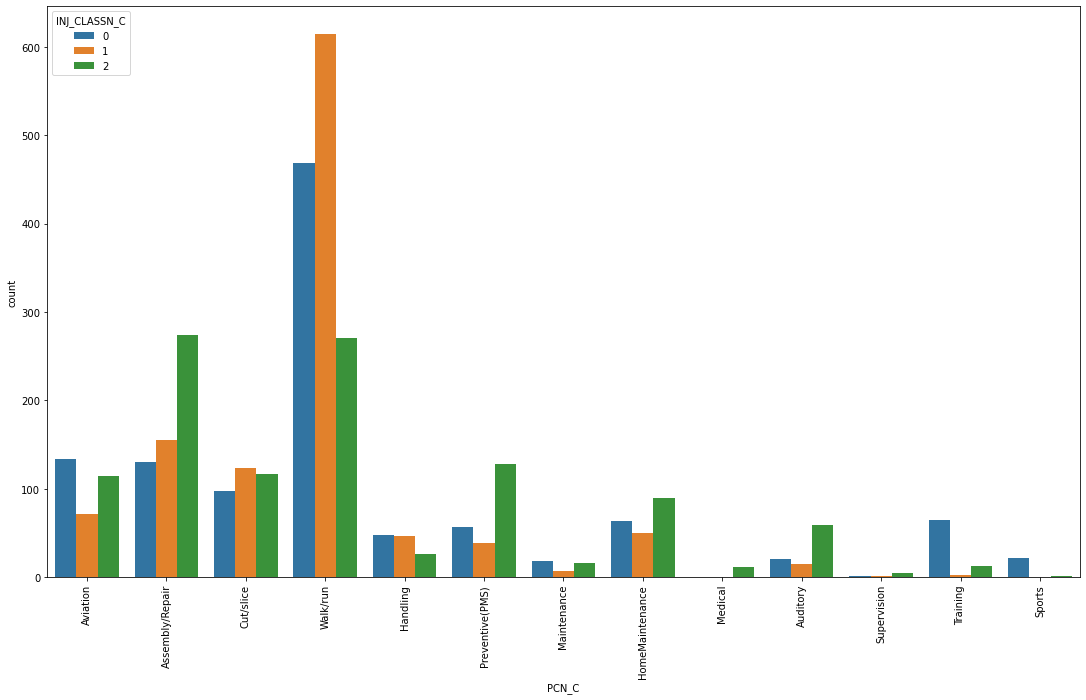

In [109]:

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
sns.countplot(data=dx, x="PCN_C", hue="INJ_CLASSN_C", ax = ax)
labels = [item.get_text() for item in ax.get_xticklabels()]

labels = ["Aviation","Assembly/Repair","Cut/slice","Walk/run","Handling","Preventive(PMS)","Maintenance","HomeMaintenance","Medical","Auditory","Supervision","Training","Sports"]
ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.show()

### Ordinal data

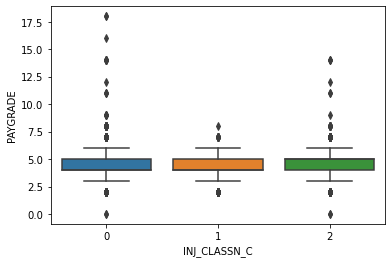

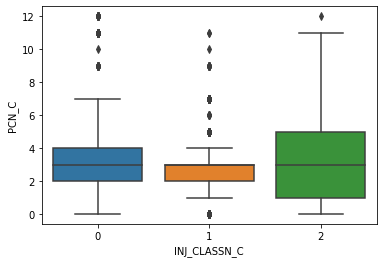

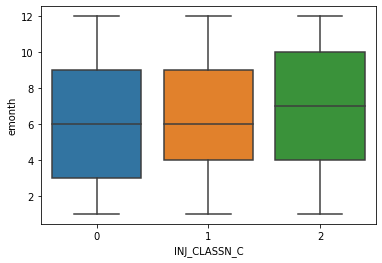

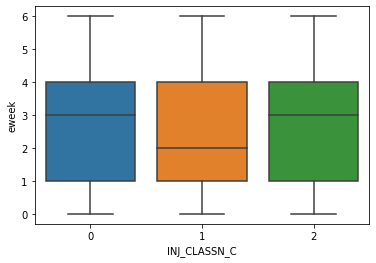

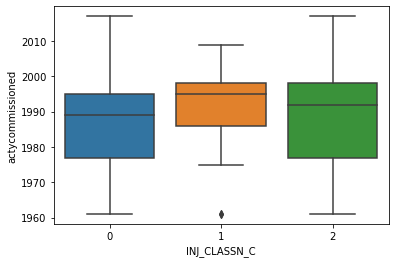

In [35]:
['PAYGRADE', 'PCN_C', 'AGE', 'SEX_C', 'FY', 'VESL_TYPE',
       'emonth', 'eweek', 'ehrmin', 'actycommissioned', 'actydecommissioned',
       'pcnfreq', 'fd_words', 'ac_words', 'passage_words', 'hg_words',
       'ece_words', 'mech_words', 'cargo_words', 'gen_words','INJ_CLASSN_C']

sns.boxplot(y="PAYGRADE", x="INJ_CLASSN_C", data=dx)
plt.show()

sns.boxplot(y="PCN_C", x="INJ_CLASSN_C", data=dx)
plt.show()

sns.boxplot(y="emonth", x="INJ_CLASSN_C", data=dx)
plt.show()

sns.boxplot(y="eweek", x="INJ_CLASSN_C", data=dx)
plt.show()

sns.boxplot(y="actycommissioned", x="INJ_CLASSN_C", data=dx)
plt.show()

### Classification

In [54]:
df1.columns
df2 = df1.copy()

In [55]:
df1 = df2.copy()

In [56]:
y = df1['INJ_CLASSN_C']
X = df1.drop(['INJ_CLASSN_C'], axis=1)

X = pd.get_dummies(X, 
               prefix = ['PCN_C','AREA','actyrank'], 
               columns = ['PCN_C','AREA','actyrank'], 
               drop_first=True, dtype = int) 

In [57]:
features = X.columns.to_list()
features

['AGE',
 'SEX_C',
 'FY',
 'emonth',
 'ehrmin',
 'PCN_C_1',
 'PCN_C_2',
 'PCN_C_3',
 'PCN_C_4',
 'PCN_C_5',
 'PCN_C_6',
 'PCN_C_7',
 'PCN_C_8',
 'PCN_C_10',
 'PCN_C_11',
 'PCN_C_12',
 'AREA_1',
 'AREA_2',
 'AREA_3',
 'AREA_4',
 'AREA_5',
 'AREA_6',
 'AREA_7',
 'AREA_8',
 'actyrank_1',
 'actyrank_2',
 'actyrank_3',
 'actyrank_4',
 'actyrank_5',
 'actyrank_6',
 'actyrank_7',
 'actyrank_8',
 'actyrank_9',
 'actyrank_10',
 'actyrank_11',
 'actyrank_12',
 'actyrank_13']

In [58]:
#use xgboost with default parameters
xgbbasic = xgb.sklearn.XGBClassifier(
                    max_depth=1
                   )
#xgb.sklearn.XGBClassifier()

start = time.time()
results = cross_val_score(xgbbasic, X, y, cv=10)
end = time.time()
print("CV accuracy for XGboost Classifier: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

CV accuracy for XGboost Classifier: Mean = 58.764%, STD = 11.08%
Execution time: 0.20 min


In [60]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(xgbbasic, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
df_cm = pd.DataFrame(conf_mat, range(4), range(4))
df_cm

,0,1,2,3
0,0,0,12,4
1,0,50,671,84
2,0,23,2514,283
3,0,28,796,145


In [61]:
# plot feature importance
xgbbasic.fit(X,y)
preds = xgbbasic.predict(X)
print("Training accuracy:", accuracy_score(y, preds))

Training accuracy: 0.6418655097613882


In [62]:
feature_important = xgbbasic.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

In [63]:
pcnv = 0
for i,k in enumerate(keys):
    if "PCN_C" in k:
        pcnv += values[i]**2
values += [round(np.sqrt(pcnv))]
keys += ['PCN_C']

pcnv = 0
for i,k in enumerate(keys):
    if "AREA" in k:
        pcnv += values[i]**2
values += [round(np.sqrt(pcnv))]
keys += ['AREA']

pcnv = 0
for i,k in enumerate(keys):
    if 'actyrank' in k:
        pcnv += values[i]**2
values += [round(np.sqrt(pcnv))]
keys += ['actyrank']

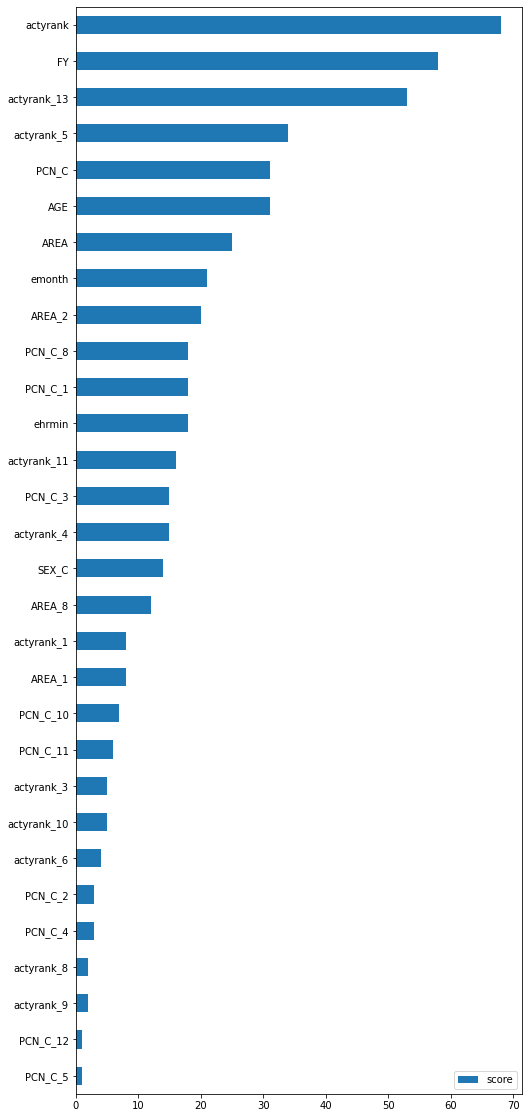

In [64]:
#keys = keys+['PCN_C']
#values = list(feature_important.values())
#values = values + [round(np.sqrt(values[6]**2+values[9]**2+values[11]**2+values[13]**2+values[14]**2
#                                +values[15]**2+values[16]**2+values[17]**2+values[18]**2+values[20]**2))] #6 9 111314151617182021
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize=(8,20))
plt.show()

In [65]:
#use random forest with default parameters
rfbasic = RandomForestClassifier(bootstrap= True,
                                 max_depth= 4,
                                 max_features= 8,
                                 min_samples_leaf= 3,
                                 min_samples_split= 6,
                                 n_estimators= 600)

start = time.time()
results = cross_val_score(rfbasic, X, y, cv=10)
end = time.time()
print("CV accuracy for Random Forrest Classifier: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

CV accuracy for Random Forrest Classifier: Mean = 62.126%, STD = 1.96%
Execution time: 0.25 min


In [66]:
#generate test prediction for submission
rfbasic.fit(X,y)
preds = rfbasic.predict(X)
print("Training accuracy:", accuracy_score(y, preds))

Training accuracy: 0.6407809110629067


In [67]:
keys = X.columns.to_list()
values = rfbasic.feature_importances_.tolist()
pcnv = 0
for i,k in enumerate(keys):
    if "PCN_C" in k:
        pcnv += values[i]**2
        print(i,k)
values += [(np.sqrt(pcnv))]
keys += ['PCN_C']

pcnv = 0
for i,k in enumerate(keys):
    if "AREA" in k:
        pcnv += values[i]**2
values += [(np.sqrt(pcnv))]
keys += ['AREA']

pcnv = 0
for i,k in enumerate(keys):
    if 'actyrank' in k:
        pcnv += values[i]**2
values += [(np.sqrt(pcnv))]
keys += ['actyrank']

5 PCN_C_1
6 PCN_C_2
7 PCN_C_3
8 PCN_C_4
9 PCN_C_5
10 PCN_C_6
11 PCN_C_7
12 PCN_C_8
13 PCN_C_10
14 PCN_C_11
15 PCN_C_12


In [68]:
len(keys)

40

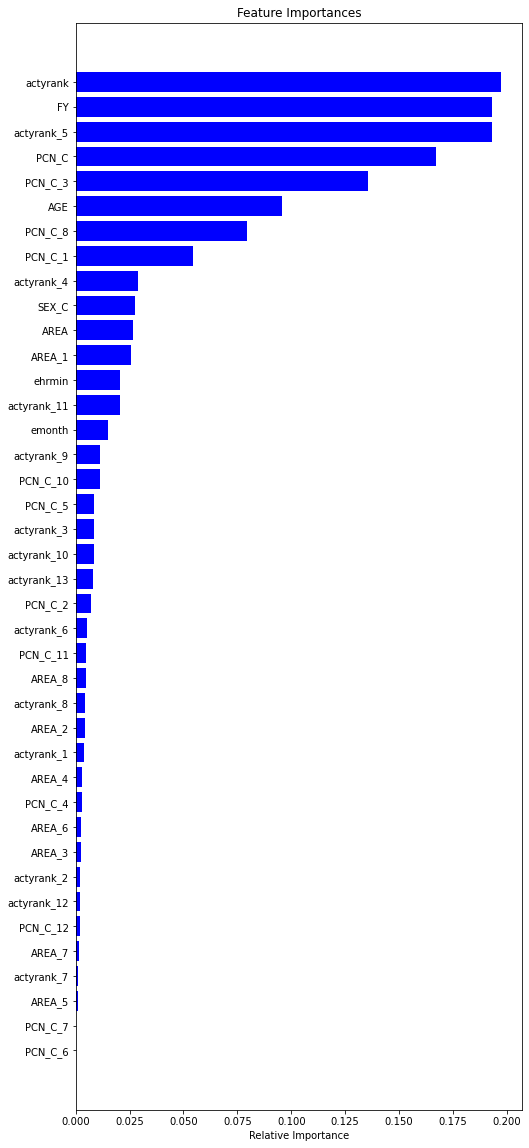

In [69]:
features= keys
indices = np.argsort(values)
importances = np.array(values)
plt.figure(figsize=(8,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [78]:
# remove
X1 = X.copy()
#X.drop(['ac_words','cargo_words','gen_words','PCN_C','SEX_C'],axis=1,inplace= True)

from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth = 2)
start = time.time()
results = cross_val_score(clf, X, y, cv=10)
end = time.time()
print("CV accuracy for CART: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

CV accuracy for CART: Mean = 61.649%, STD = 1.04%
Execution time: 0.00 min


In [79]:
#generate test prediction for submission
clf.fit(X,y)
preds = clf.predict(X)
print("Training accuracy:", accuracy_score(y, preds))

Training accuracy: 0.6247288503253796


In [80]:
keys = X.columns.to_list()
values = clf.feature_importances_.tolist()
pcnv = 0
for i,k in enumerate(keys):
    if "PCN_C" in k:
        pcnv += values[i]**2
        print(i,k)
values += [(np.sqrt(pcnv))]
keys += ['PCN_C']

pcnv = 0
for i,k in enumerate(keys):
    if "AREA" in k:
        pcnv += values[i]**2
values += [(np.sqrt(pcnv))]
keys += ['AREA']

pcnv = 0
for i,k in enumerate(keys):
    if 'actyrank' in k:
        pcnv += values[i]**2
values += [(np.sqrt(pcnv))]
keys += ['actyrank']

5 PCN_C_1
6 PCN_C_2
7 PCN_C_3
8 PCN_C_4
9 PCN_C_5
10 PCN_C_6
11 PCN_C_7
12 PCN_C_8
13 PCN_C_10
14 PCN_C_11
15 PCN_C_12


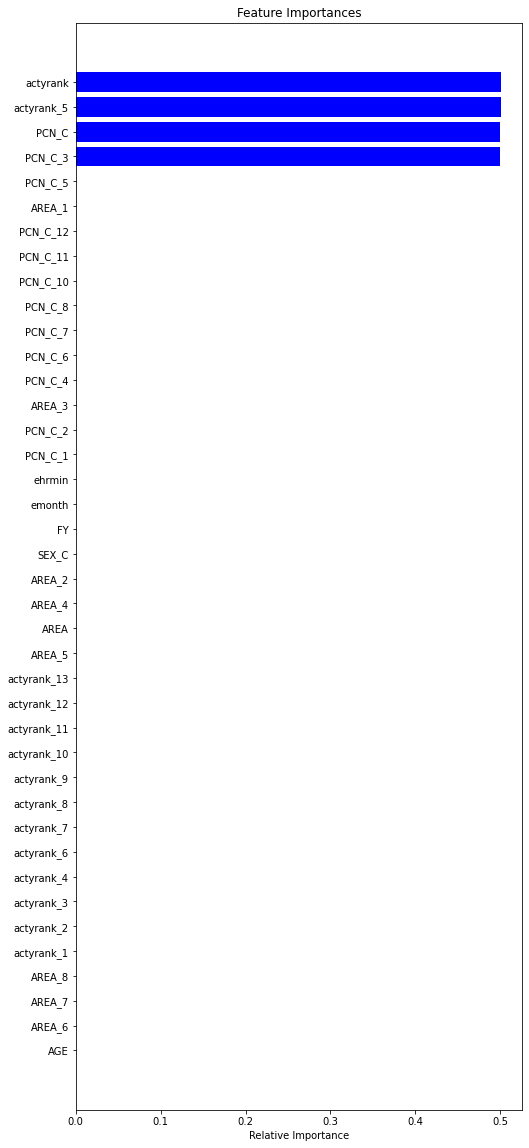

In [81]:
features= keys
indices = np.argsort(values)
importances = np.array(values)
plt.figure(figsize=(8,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

AGE: 0
SEX_C: 1
FY: 2
emonth: 3
ehrmin: 4
PCN_C_1: 5
PCN_C_2: 6
PCN_C_3: 7
PCN_C_4: 8
PCN_C_5: 9
PCN_C_6: 10
PCN_C_7: 11
PCN_C_8: 12
PCN_C_10: 13
PCN_C_11: 14
PCN_C_12: 15
AREA_1: 16
AREA_2: 17
AREA_3: 18
AREA_4: 19
AREA_5: 20
AREA_6: 21
AREA_7: 22
AREA_8: 23
actyrank_1: 24
actyrank_2: 25
actyrank_3: 26
actyrank_4: 27
actyrank_5: 28
actyrank_6: 29
actyrank_7: 30
actyrank_8: 31
actyrank_9: 32
actyrank_10: 33
actyrank_11: 34
actyrank_12: 35
actyrank_13: 36
PCN_C: 37
AREA: 38
actyrank: 39


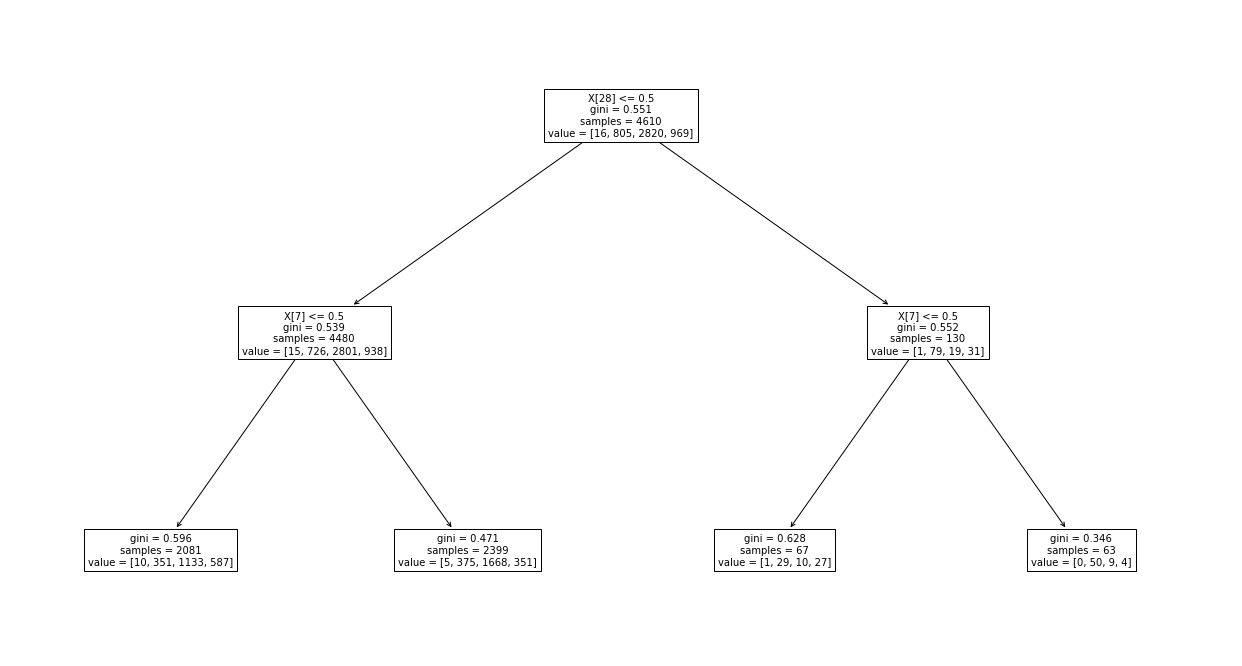

In [82]:
for e,i in enumerate(features):
    print(i+': '+str(e))

fig, ax = plt.subplots(figsize=(22, 12))
tree.plot_tree(clf, fontsize=10)
plt.show()

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [85]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter = 150)
start = time.time()
results = cross_val_score(clf, X, y, cv=10)
end = time.time()
print("CV accuracy for LR: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

CV accuracy for LR: Mean = 63.189%, STD = 4.43%
Execution time: 0.04 min


In [86]:
#generate test prediction for submission
clf.fit(X,y)
preds = clf.predict(X)
print("Training accuracy:", accuracy_score(y, preds))

Training accuracy: 0.661822125813449


In [87]:
keys = features[:-3]
values = abs(np.array(clf.coef_[0].tolist())).tolist()
pcnv = 0
for i,k in enumerate(keys):
    if "PCN_C" in k:
        pcnv += values[i]**2
        print(i,k)
values += [(np.sqrt(pcnv))]
keys += ['PCN_C']

pcnv = 0
for i,k in enumerate(keys):
    if "AREA" in k:
        pcnv += values[i]**2
values += [(np.sqrt(pcnv))]
keys += ['AREA']

pcnv = 0
for i,k in enumerate(keys):
    if 'actyrank' in k:
        pcnv += values[i]**2
values += [(np.sqrt(pcnv))]
keys += ['actyrank']

5 PCN_C_1
6 PCN_C_2
7 PCN_C_3
8 PCN_C_4
9 PCN_C_5
10 PCN_C_6
11 PCN_C_7
12 PCN_C_8
13 PCN_C_10
14 PCN_C_11
15 PCN_C_12


In [88]:
keys

['AGE',
 'SEX_C',
 'FY',
 'emonth',
 'ehrmin',
 'PCN_C_1',
 'PCN_C_2',
 'PCN_C_3',
 'PCN_C_4',
 'PCN_C_5',
 'PCN_C_6',
 'PCN_C_7',
 'PCN_C_8',
 'PCN_C_10',
 'PCN_C_11',
 'PCN_C_12',
 'AREA_1',
 'AREA_2',
 'AREA_3',
 'AREA_4',
 'AREA_5',
 'AREA_6',
 'AREA_7',
 'AREA_8',
 'actyrank_1',
 'actyrank_2',
 'actyrank_3',
 'actyrank_4',
 'actyrank_5',
 'actyrank_6',
 'actyrank_7',
 'actyrank_8',
 'actyrank_9',
 'actyrank_10',
 'actyrank_11',
 'actyrank_12',
 'actyrank_13',
 'PCN_C',
 'AREA',
 'actyrank']

In [89]:
(abs(np.array(clf.coef_[0].tolist())))

array([0.28297826, 0.30461451, 0.05778956, 0.32586638, 0.16988006,
       0.22631732, 0.0200705 , 0.08690081, 0.26795366, 0.14527097,
       0.10300187, 0.18675707, 0.02832194, 0.09536934, 0.16863655,
       0.25799406, 0.37868946, 0.06969606, 0.15490966, 0.28954203,
       0.48145242, 0.07449084, 0.5836971 , 0.77494942, 0.47026795,
       0.19465483, 0.35397385, 0.36253304, 0.052461  , 0.11827322,
       0.16989723, 0.08878376, 0.10625103, 0.43511566, 0.16372474,
       0.63752892, 0.11669898])

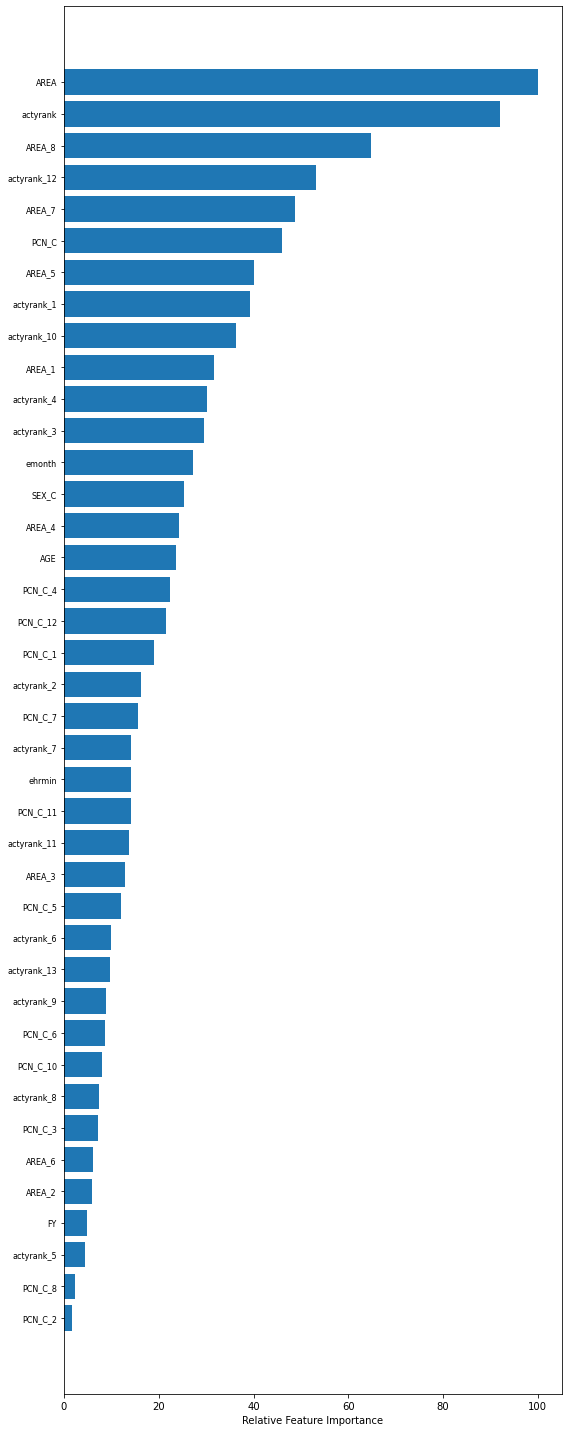

In [90]:
#features = X.columns.to_list()
feature_importance = np.array(values)#abs(np.array(clf.coef_[0].tolist() + [np.sqrt(np.sum(np.array(clf.coef_[0].tolist()[11:])**2))]))
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


featfig = plt.figure(figsize=(8,20))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(keys)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [128]:
len(clf.coef_[0])

37

In [87]:
import eli5
eli5.show_weights(clf)

C:\Users\sayan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\sayan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [227]:
import pandas as pd
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
%matplotlib inline


# define the validation scheme
cv = KFold(n_splits=5, shuffle=False, random_state=0)

# define the binary target and the features
dataset = Dataset(df=dx, target="'INJ_CLASSN_C'", features=[col for col in dx.columns if col != target])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [232]:
clf.coef_[0].tolist() + [np.sqrt(np.sum(np.array(clf.coef_[0].tolist()[12:])**2))]

[-0.03314140740247562,
 0.15911934705375552,
 -0.13235132097405386,
 -0.037375685376351726,
 0.016886274731927414,
 -0.0019518845969808203,
 -0.12299941031390298,
 -0.19690064240609964,
 0.10456349783586358,
 -0.006186632313913058,
 0.002937682209240407,
 -0.0400536863331849,
 -0.16428653839592394,
 -0.008673920949336288,
 -0.1457203751703246,
 0.09805511927571949,
 -0.015343295577228598,
 0.19052331775711412,
 -0.0044859886220496225,
 0.2206952245205878,
 0.0752896905555944,
 0.12679316037635882,
 0.22662169623475772,
 0.46505701965852075]

In [97]:
nadf['INJ_CLASSN'].value_counts()

LIGHT/LIMITED DUTY OR RESTRICTED WORK (NO LOST WORK DAYS)    3944
OTHER REPORTABLE AND MEDICAL TREATMENT/NO LOST TIME          1458
ONE OR MORE LOST WORK DAYS                                   1097
NO INJURY OR ILLNESS                                          231
FIRST AID TREATMENT ONLY/FIRST AID CASE                       224
PERMANENT PARTIAL DISABILITY                                   26
FATAL                                                           6
Name: INJ_CLASSN, dtype: int64

In [102]:
df1['INJ_CLASSN_C'].value_counts()

1    3940
2    1899
0    1125
Name: INJ_CLASSN_C, dtype: int64

In [104]:
nadf['SEX_C'].value_counts()

M    5339
F    1646
Name: SEX_C, dtype: int64

In [114]:
dfcopy['SEX_C'].value_counts()

M    5323
F    1641
Name: SEX_C, dtype: int64

In [34]:
nadf = nadf.drop_duplicates()


nadf['AGE'].fillna(22, inplace=True) #replace missing age with median age
nadf['AGE'] = nadf['AGE'].replace(99,22)#delete
nadf['AGE'] = nadf['AGE'].replace(0,22)

In [41]:
na = nadf[(nadf['AGE']==16) | (nadf['AGE']>=65)]

In [54]:
df1 = df1[~df1['BRIEF_NARR'].str.contains("civ", na=False,case=False)]

In [60]:
df1[(df1["AGE"] > 16) & (df1["AGE"] < 65)]

,284,1043
INVLVD_PER_SERL,20867,53931
PAYGRADE,E03,E04
RANK_RATE,SN,PO3
RATEG,CSSN,AT3
DESG_C,NaN,NaN
NEC_C,NaN,NaN
PCN_C,CL-00-00,CL-00-00
AREA_C,1G09096,1G09024
INJ_CLASSN_C,F,G
AGE,15,15


In [59]:
df1[(df1["AGE"] > 65)]

,INVLVD_PER_SERL,PAYGRADE,RANK_RATE,RATEG,DESG_C,NEC_C,PCN_C,AREA_C,INJ_CLASSN_C,AGE,...,EVOL,RPRTBL_EVENT_SERL,EVENT_DATE_TIME,FY,BRIEF_NARR,RPRTG_UNIT_CODE,EVENT_SEVTY_C,INVLVD_UNIT_CODE,ACTY_NAME_LONG,VESL_TYPE


In [180]:
df1

,PAYGRADE,PCN_C,INJ_CLASSN_C,AGE,SEX_C,AREA,FY,emonth,ehrmin,actyrank
0,4,3,2,21.0,0,1,2006,4,230,8
1,5,3,2,26.0,0,1,2006,4,2200,8
2,6,1,2,42.0,0,1,2006,9,1020,4
3,5,3,1,24.0,0,3,2006,12,1230,11
4,4,3,3,25.0,0,6,2006,12,1930,6
...,...,...,...,...,...,...,...,...,...,...
7318,3,2,2,22.0,0,8,2019,4,1030,10
7320,5,0,2,28.0,0,6,2019,4,2000,7
7321,6,3,1,31.0,0,2,2019,7,1445,7
7322,5,4,2,22.0,0,8,2019,7,1400,7


In [23]:
cats = ['A', 'B', 'C', 'D','E','F','G','H']
for i in range(len(cats)):
    nadf[col[8]] = nadf[col[8]].replace(cats[i], i)

In [28]:
counter1 = Counter(nadf['INJ_CLASSN_C'].dropna())
print(counter1)
for k,v in counter1.items():
	per = v / len(nadf['INJ_CLASSN_C']) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Counter({4.0: 3944, 5.0: 1458, 3.0: 1097, 7.0: 231, 6.0: 224, 2.0: 26, 0.0: 6})
Class=4, n=3944 (53.843%)
Class=3, n=1097 (14.976%)
Class=6, n=224 (3.058%)
Class=5, n=1458 (19.904%)
Class=7, n=231 (3.154%)
Class=2, n=26 (0.355%)
Class=0, n=6 (0.082%)
